In [2]:
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout,  Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import tensorflow as tf
from pathlib import Path
import os.path
import pandas as pd
import keras
from keras import regularizers

In [12]:
strategy = tf.distribute.MirroredStrategy()

Tạo dataframe gồm 2 cột là Filepath và Age từ dữ liệu 

In [3]:
image_dir = Path('D:/Huan/Learning/DL/data/UTKFace')
filepaths = pd.Series(list(image_dir.glob(r'*.jpg.chip.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(x)[-1].split('_')[0]), name='Age').astype(int)
images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=100).reset_index(drop=True)

# Chia dữ liệu thành 2 phần train và test với tỉ lệ 9:1
train_df, test_df = train_test_split(images, test_size = 0.1, random_state = 0)

In [4]:
print(images)

                                                Filepath  Age
0      D:\Huan\Learning\DL\data\UTKFace\39_0_0_201701...   39
1      D:\Huan\Learning\DL\data\UTKFace\95_1_0_201701...   95
2      D:\Huan\Learning\DL\data\UTKFace\12_1_0_201701...   12
3      D:\Huan\Learning\DL\data\UTKFace\25_0_3_201701...   25
4      D:\Huan\Learning\DL\data\UTKFace\24_1_3_201701...   24
...                                                  ...  ...
23702  D:\Huan\Learning\DL\data\UTKFace\10_0_0_201701...   10
23703  D:\Huan\Learning\DL\data\UTKFace\32_1_1_201701...   32
23704  D:\Huan\Learning\DL\data\UTKFace\36_1_3_201701...   36
23705  D:\Huan\Learning\DL\data\UTKFace\8_1_0_2017010...    8
23706  D:\Huan\Learning\DL\data\UTKFace\25_1_3_201701...   25

[23707 rows x 2 columns]


Tạo các batches dữ liệu từ Dataframe chứa các đường dẫn đến hình ảnh và các nhãn tương ứng

In [15]:
image_size = (128,128)
batch = 256

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.1,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=image_size,
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch,
    shuffle=True,
    seed=42,
    subset='training',
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=image_size,
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch,
    shuffle=True,
    seed=42,
    subset='validation',
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch,
    shuffle=False
)


Found 19203 validated image filenames.
Found 2133 validated image filenames.
Found 2371 validated image filenames.


Tạo, cấu hình và huấn luyện mô hình

In [16]:
with strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', activity_regularizer=regularizers.L2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    epochs = 25
    model.compile(optimizer=keras.optimizers.Adam(),
                loss='mae',
                metrics = ['mse'])

    callbacks = [keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        mode="auto",
        restore_best_weights=True,
        patience=5
    ),]

    model.summary()
    H = model.fit(
        train_images,
        validation_data=val_images,
        epochs=epochs,
        callbacks = callbacks,
        verbose = 1,
    )

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 40s 428ms/step - loss: 25.3925 - mse: 732.5250 - val_loss: 20.0024 - val_mse: 490.0968
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 400ms/step - loss: 18.7725 - mse: 429.3483 - val_loss: 16.1030 - val_mse: 361.5640
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 410ms/step - loss: 16.7268 - mse: 357.2050 - val_loss: 14.3803 - val_mse: 261.7512
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 406ms/step - loss: 14.5694 - mse: 276.2909 - val_loss: 13.6645 - val_mse: 249.1821
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 408ms/step - loss: 13.6064 - mse: 238.8683 - val_loss: 15.2369 - val_mse: 257.6950
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 408ms/step - loss: 14.3734 - mse: 282.2211 - val_loss: 12.5791 - val_mse: 263.2836
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 413ms/step - loss: 12.5585 - mse: 218.9911 - val_loss: 11.0323 - val_mse: 183.5411
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 416ms/step - loss: 12.4373 - mse: 212.1910 - val_loss: 11.0888 - val_mse: 163.1601
Epoch 9/25


Vẽ đồ thị để đánh giá mô hình

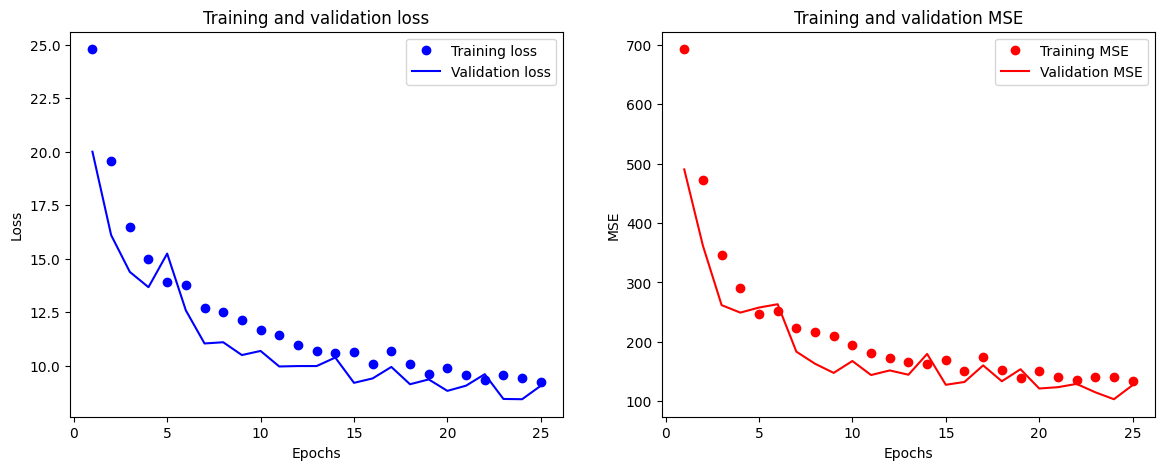

In [17]:
# Lấy dữ liệu từ lịch sử huấn luyện
loss = H.history['loss']
val_loss = H.history['val_loss']
mse = H.history['mse']
val_mse = H.history['val_mse']
epochs = range(1, len(loss) + 1)

# Vẽ đồ thị hàm mất mát
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Vẽ đồ thị MSE
plt.subplot(1, 2, 2)
plt.plot(epochs, mse, 'ro', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()


Lưu mô hình

In [18]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# Lưu trọng số của model vào tệp .h5
model.save_weights("model.weights.h5")

Đánh giá kết quả với tập test

In [19]:
model.evaluate(test_images)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 528ms/step - loss: 8.9095 - mse: 117.5757


[8.671160697937012, 115.8902816772461]